This notebooks plots some descriptive statistics of the raw text data.


## Inputs

- `data/pubmed/abstracts.csv.gz`: raw text data

In [31]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from python.cogtext.datasets.pubmed import PubMedDataLoader

sns.set('notebook')

In [32]:
DATA_DIR = '../cogtext_data/pubmed/'
data = PubMedDataLoader(root_dir=DATA_DIR, preprocessed=False).load()

In [33]:
n_articles = len(data.index)
n_unique_articles = data['pmid'].nunique()
print(f'Dataset contains {n_articles} articles, of that {n_unique_articles} are unique.')

Dataset contains 522972 articles, of that 385705 are unique.


/Users/morteza/micromamba/envs/cogtext/lib/python3.10/site-packages/seaborn/categorical.py:3202: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


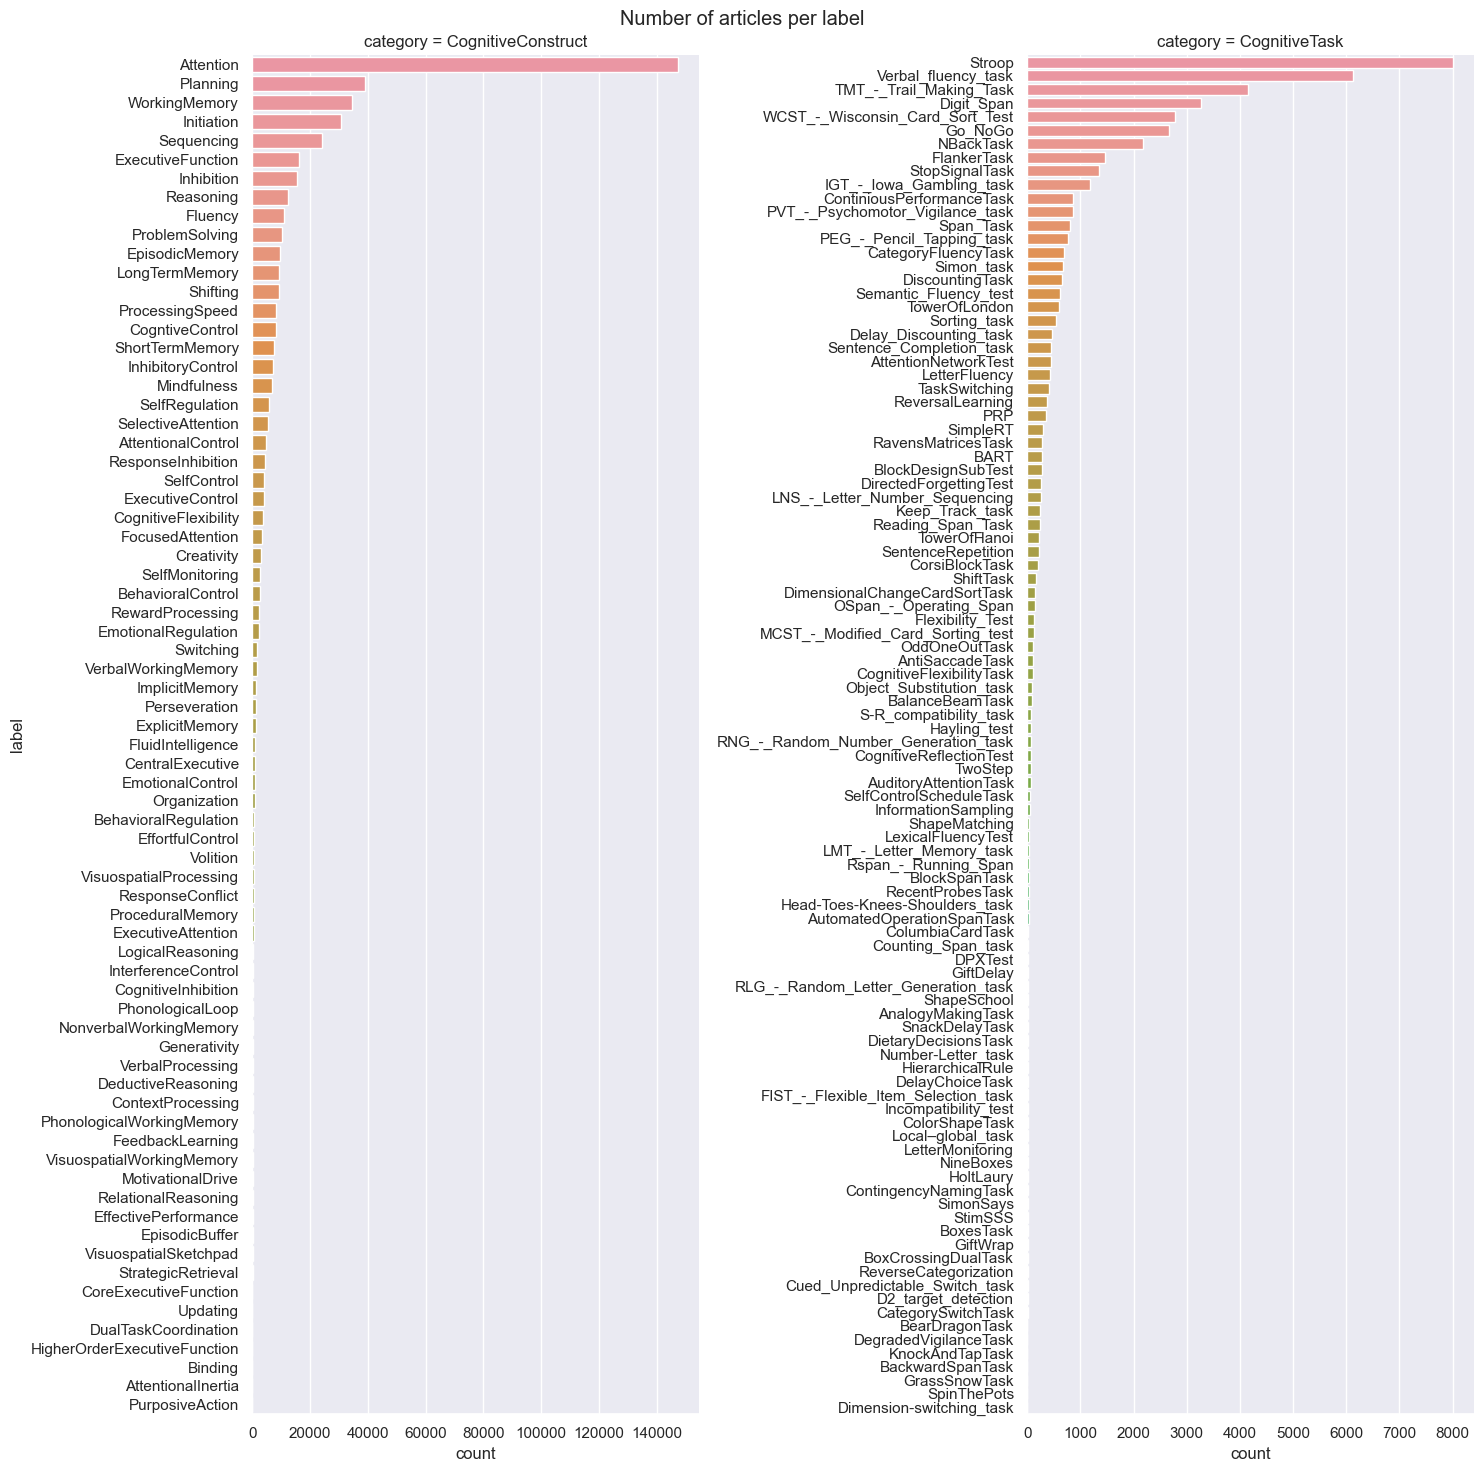

In [50]:
# plot number of articles for each lexicon term (or labels).

plot_data = data.groupby(['category','label'])[['pmid']].nunique().reset_index().sort_values('pmid', ascending=False)
plot_data.rename(columns={'pmid': 'count'}, inplace=True)

sns.catplot(data=plot_data, x='count', y='label', col='category',
            orient='h', kind='bar', height=15, aspect=0.5,
            sharex=False, sharey=False)

plt.suptitle('Number of articles per label')
plt.tight_layout()
plt.show()

In [57]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(counts)

min_year, max_year = data.query('label == "Stroop"')['year'].apply([min, max])
print(f'Stroop articles span from {min_year} to {max_year}.')

Stroop articles span from 1973 to 2022.


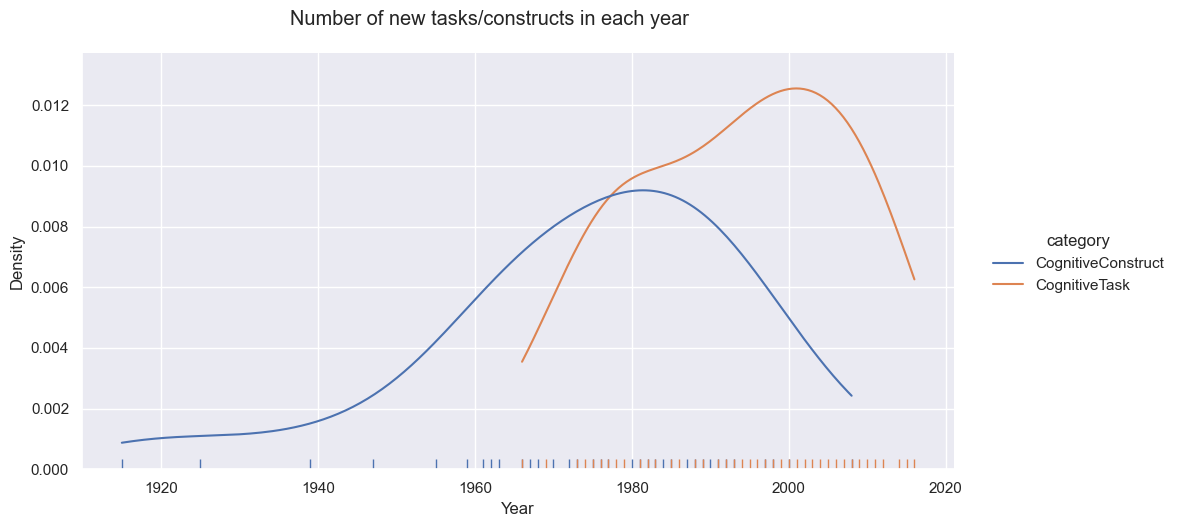

In [58]:
# plot first appearance of task/construct as a function of time

appearances = data.groupby(['category','label'])['year'].min().reset_index()

import seaborn as sns

appearances = appearances.groupby(['year','category']).nunique().reset_index()

# 2021 corpus is incomplete, so we drop it
appearances = appearances.query('year <= 2020')

# sns.kdeplot(x='year', data=appearances, hue='category', ax=ax, cut=0)
sns.displot(
  x='year',
  data=appearances,
  hue='category',
  kind='kde', cut=0, rug=True,
  height=5, aspect=2)

plt.suptitle('Number of new tasks/constructs in each year', y=1.05, x=.42)
plt.xlabel('Year')
# ax.legend_.set_title(None)
plt.show()

In [59]:
# report first and last years of the "first appearances'

appearances.groupby(['category']).agg({'year': ['min','max']})

year      
                     min   max
category                      
CognitiveConstruct  1915  2008
CognitiveTask       1966  2016